In [1]:
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import torch

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['figure.figsize'] = [9, 7]


# Append ../src to path
import sys
source_path =  os.path.join(os.getcwd(), '../src')
if source_path not in sys.path:
    sys.path.append(source_path)
    

## 1. Get the datasets

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

train_dataset = MNIST(root='../data/', download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root='../data/', download=True, train=False, transform=ToTensor())


## 2. Define NN

In this example, we use the convmixer architecture


code source: https://github.com/locuslab/convmixer-cifar10/blob/main/train.py

In [3]:
import torch.nn as nn 

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    
def build_convmixer(dim, patch_size, kernel_size, depth, num_classes):
    return nn.Sequential(
            nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(dim),
            *[
                nn.Sequential(
                    Residual(
                        nn.Sequential(
                            nn.Conv2d(
                                dim, dim, kernel_size, groups=dim, padding="same"
                            ),
                            nn.GELU(),
                            nn.BatchNorm2d(dim),
                        )
                    ),
                    nn.Conv2d(dim, dim, kernel_size=1),
                    nn.GELU(),
                    nn.BatchNorm2d(dim),
                )
                for _ in range(depth)
            ],
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, num_classes)
    )

## 3. Train and test functions

In [4]:

def train(net, train_dataset, optimizer, max_epochs, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    trainloader = DataLoader(train_dataset, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             num_workers=2)

    logs = {'train_loss': []}
    for epoch in range(max_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            logs['train_loss'].append(loss.item())
            
        print(f"Epoch {epoch+1}, loss: {running_loss / len(trainloader): .2f}")
    print('Finished Training')
    return net, logs

def test(test_dataset, net, batch_size):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    testloader = DataLoader(test_dataset, 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=2,
                            drop_last=False,
                            )

    # logs = {'test_accuracy': []}
    correct_clfs = 0.
    running_loss = 0.
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward 
        logits = net(inputs)
        loss = criterion(logits, labels)
        
        running_loss += loss.item()

        correct_clfs += (logits.argmax(dim=1) == labels).float().sum().item()
    N_points = len(test_dataset)
    return running_loss / N_points, correct_clfs / N_points


## 4. Compare to Adam and SGD

In [14]:
from vsgd import VSGD

net = build_convmixer(dim=16, patch_size=2, kernel_size=3, depth=4, num_classes=10)
vsgd = VSGD(net.parameters(), lr=0.01, ps=1e-7)
net, logs_vsgd = train(net, train_dataset, vsgd, max_epochs=3, batch_size=32)
logs_vsgd['test_loss'], logs_vsgd['test_acc'] = test(test_dataset, net, 32)

acc = logs_vsgd['test_acc']*100
print(f'Test accuracy:  {acc:.2f}%')

Epoch 1, loss:  0.27
Epoch 2, loss:  0.10
Epoch 3, loss:  0.09
Finished Training
Test accuracy:  98.08%


In [17]:
from torch.optim import SGD

sgd_net = build_convmixer(dim=16, patch_size=2, kernel_size=3, depth=4, num_classes=10)
sgd = SGD(sgd_net.parameters(), lr=0.01, momentum=0.9)
sgd_net, logs_sgd = train(sgd_net, train_dataset, sgd, max_epochs=3, batch_size=32)
logs_sgd['test_loss'], logs_sgd['test_acc'] = test(test_dataset, sgd_net, 32)

acc = logs_sgd['test_acc']*100
print(f'Test accuracy:  {acc:.2f}%')

Epoch 1, loss:  0.57
Epoch 2, loss:  0.13
Epoch 3, loss:  0.10
Finished Training
Test accuracy:  97.81%


In [15]:
from torch.optim import Adam

adam_net = build_convmixer(dim=16, patch_size=2, kernel_size=3, depth=4, num_classes=10)
adam = Adam(adam_net.parameters(), lr=0.01)
adam_net, logs_adam = train(adam_net, train_dataset, adam, max_epochs=3, batch_size=32)
logs_adam['test_loss'], logs_adam['test_acc'] = test(test_dataset, adam_net, batch_size=32)

acc = logs_adam['test_acc']*100
print(f'Test accuracy:  {acc:.2f}%')

Epoch 1, loss:  0.24
Epoch 2, loss:  0.10
Epoch 3, loss:  0.09
Finished Training
Test accuracy:  97.68%


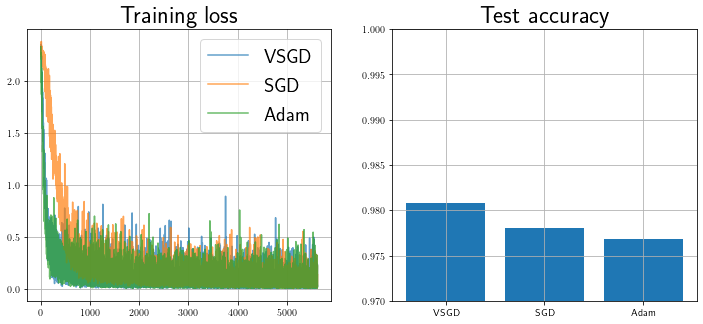

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(logs_vsgd['train_loss'], label='VSGD', alpha=0.7)
ax[0].plot(logs_sgd['train_loss'], label='SGD', alpha=0.7)
ax[0].plot(logs_adam['train_loss'], label='Adam', alpha=0.7)
ax[0].legend(fontsize=20)
ax[0].grid()
ax[0].set_title('Training loss', fontsize=24)

ax[1].bar(['VSGD', 'SGD', 'Adam'], [logs_vsgd['test_acc'], logs_sgd['test_acc'], logs_adam['test_acc']]);
ax[1].grid()
ax[1].set_ylim(0.97, 1.0);
ax[1].set_title('Test accuracy', fontsize=24);